# Predicting Movie Performance

I have compiled data for all the movies from 2011-2016 that had an opening US weekend box office total of $10m or more. We have some limited data points for each movie including genre, creative source, and production budget. Given the data for films from 2011-2015, can we predict the results of movies in 2016?

We'll be using a variety of decision tree techniques, including random forests and boosted trees.

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [4]:
#pip install pydot
import pydot
import StringIO

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation
Here we'll be using pandas (http://pandas.pydata.org/) to import our data sets and ready our data for analysis. I've made sure that the data is already pretty normalized to make things easy on us.

However, scikit-learn doesn't support categorical features in its decision trees. We'll need to convert all of our categorical columns to numerical columns using one-hot encoding.

In [6]:
train = pd.read_csv('train.csv',parse_dates=[0])
trainY = train['Infl. Adj. Dom. Box Office']
del train['Infl. Adj. Dom. Box Office']

test = pd.read_csv('test.csv',parse_dates=[0])
testY = test['Infl. Adj. Dom. Box Office']
del test['Infl. Adj. Dom. Box Office']

train.head()
#trainY.head()

,Released,Title,Theatrical Distributor,Genre,Source,Production Method,Creative Type,Production Budget,Theatrical Engagements
0,2013-04-12,42,Warner Bros.,Drama,Based on Real Life Events,Live Action,Dramatization,40000000,21418
1,2013-08-02,2 Guns,Universal,Action,Based on Comic/Graphic Novel,Live Action,Contemporary Fiction,61000000,15505
2,2012-03-16,21 Jump Street,Sony Pictures,Comedy,Based on TV,Live Action,Contemporary Fiction,42000000,22744
3,2014-06-13,22 Jump Street,Sony Pictures,Comedy,Based on TV,Live Action,Contemporary Fiction,50000000,22821
4,2014-02-21,3 Days to Kill,Relativity,Thriller/Suspense,Original Screenplay,Live Action,Contemporary Fiction,28000000,11265


In [7]:
def onehot(train=train,test=test,column='Theatrical Distributor'):
    le = LabelEncoder()
    s = train[column]
    s = s.append(test[column])
    le.fit(s)
    s1 = le.transform(train[column])
    s2 = le.transform(test[column])
    a = np.append(s1,s2).reshape(-1,1)
    oh = OneHotEncoder(sparse=False)
    oh.fit(a)
    train_out = oh.transform(s1.reshape(-1,1))
    test_out = oh.transform(s2.reshape(-1,1))
    train_df = pd.DataFrame(train_out).rename(columns=lambda x: le.inverse_transform(x))
    test_df = pd.DataFrame(test_out).rename(columns=lambda x: le.inverse_transform(x))
    return (train_df, test_df)

In [8]:
trainX = pd.DataFrame()
trainX['budget'] = train['Production Budget']
trainX['theaters'] = train['Theatrical Engagements']

testX = pd.DataFrame()
testX['budget'] = test['Production Budget']
testX['theaters'] = test['Theatrical Engagements']
categorical_features = ['Theatrical Distributor', 'Genre', 'Source', 'Production Method', 'Creative Type']
for c in categorical_features:
    (t1,t2) = onehot(column=c)
    trainX = trainX.join(t1)
    testX = testX.join(t2)
trainX.head()

,budget,theaters,20th Century Fox,CBS Films,FilmDistrict,Focus / Gramercy,Focus Features,Lionsgate,Open Road,Paramount Pictures,...,Stop-Motion Animation,Contemporary Fiction,Dramatization,Factual,Fantasy,Historical Fiction,Kids Fiction,Multiple Creative Types,Science Fiction,Super Hero
0,40000000,21418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,61000000,15505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42000000,22744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50000000,22821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28000000,11265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building Our First Decision Tree
Once you've got the data, it's surprisingly simple

In [9]:
regressor = DecisionTreeRegressor()
regressor.fit(trainX,trainY)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

## Visualizing A Tree
We have a couple tools available to us to look at tree structure / trace examples through the tree.

In [10]:
#requires graphviz installed
#brew install graphviz
dotfile = StringIO.StringIO()
tree.export_graphviz(regressor, out_file=dotfile)
(graph,) = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("tree.png")

Exception: "dot.exe" not found in path.

![Tree](tree.png)

In [11]:
def print_decision_path(tree,example):
    for decision in tree.decision_path(example).indices:
        print 'Node #{}: avg = ${:.2f}M'.format(decision,
                                              tree.tree_.value[decision][0][0]/1e6)
        print '\t decision = {} > {}? ... example_value = {}'.format(trainX.columns[tree.tree_.feature[decision]],
                                                          tree.tree_.threshold[decision],
                                                          example[trainX.columns[tree.tree_.feature[decision]]])

In [12]:
print train.iloc[25]
print '----------------------'
print_decision_path(regressor,trainX.iloc[25])

Released                           2015-07-17 00:00:00
Title                                          Ant-Man
Theatrical Distributor                     Walt Disney
Genre                                           Action
Source                    Based on Comic/Graphic Novel
Production Method                          Live Action
Creative Type                               Super Hero
Production Budget                            130000000
Theatrical Engagements                           25916
Name: 25, dtype: object
----------------------
Node #0: avg = $111.06M
	 decision = theaters > 21001.0? ... example_value = 25916.0
Node #626: avg = $228.99M
	 decision = theaters > 35699.0? ... example_value = 25916.0
Node #627: avg = $209.63M
	 decision = budget > 188750000.0? ... example_value = 130000000.0
Node #628: avg = $187.41M
	 decision = theaters > 30147.5? ... example_value = 25916.0
Node #629: avg = $172.04M
	 decision = budget > 122500000.0? ... example_value = 130000000.0
Node #713: av

C:\Users\ic3cr\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


## Evaluating The Tree

In [38]:
def evaluate(regressor, trainX=trainX, trainY=trainY):
    print 'R^2 = {:.4f}'.format(regressor.score(testX,testY))
    ypred = regressor.predict(testX)
    print 'MAE = ${:.1f}M'.format(metrics.mean_absolute_error(testY,ypred)/1e6)
    print 'Explained Variance = {:.4f}'.format(metrics.explained_variance_score(testY,ypred))
    plt.scatter(testY,regressor.predict(testX))

R^2 = 0.7208
MAE = $31.7M
Explained Variance = 0.7246


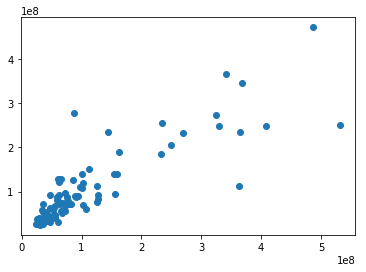

In [39]:
evaluate(regressor)

## Can We Do Better?
### Option 1: Tune Tree Parameters
Any machine learning technique we use to predict outcomes typically has hyperparameters used to control the behavoir of our methodology. Changing these characteristics will change our accuracy. For example, a tree with only 3 levels is very different than a tree with 10.

R^2 = 0.6971
MAE = $36.3M
Explained Variance = 0.7065


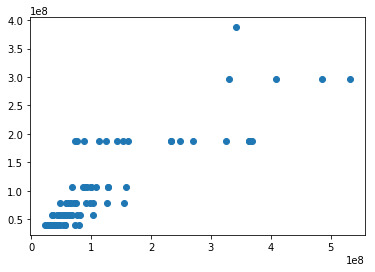

In [59]:
short_tree = DecisionTreeRegressor(max_depth=3)
short_tree.fit(trainX,trainY)
evaluate(short_tree)

In [ ]:
dotfile = StringIO.StringIO()
tree.export_graphviz(short_tree, out_file=dotfile)
(graph,) = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("short_tree.png")

![Short Tree](short_tree.png)
One way to figure out which hyper-parameters are best is simply to try them all on different subsets of data and see which performs the best. Sci-kit learn implements this in the GridSearchCV (CV=cross-validate) class.

In [42]:
cv = GridSearchCV(DecisionTreeRegressor(),
                  {'max_depth':[x+1 for x in range(10)],
                   'min_samples_leaf':[x+1 for x in range(50)]},
                  refit=True)
cv.fit(trainX,trainY)
cv_est = cv.best_estimator_
print 'Best estimator params:\n{}'.format(cv_est)

Best estimator params:
DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=9, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


R^2 = 0.7908
MAE = $30.0M
Explained Variance = 0.7975


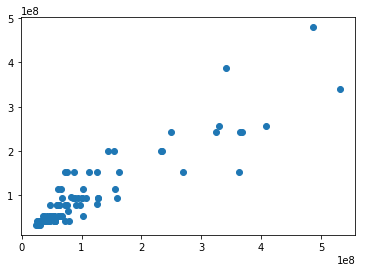

In [41]:
evaluate(cv_est)

### Option 2: Use A Different Algorithm
There are several different ensembling methods we can use to reduce some of the noise inherent in decision trees. Random Forests build many trees, using random subsets of input data and features, and average the predictions. Gradient boosted trees build many trees, focusing on training examples that are tougher to predict.

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
R^2 = 0.7921
MAE = $27.9M
Explained Variance = 0.7924


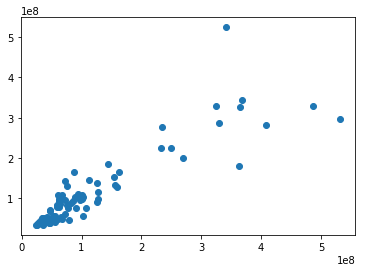

In [47]:
random_forest = RandomForestRegressor(n_estimators=500)
random_forest.fit(trainX,trainY)
print random_forest
evaluate(random_forest)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R^2 = 0.8457
MAE = $26.2M
Explained Variance = 0.8461


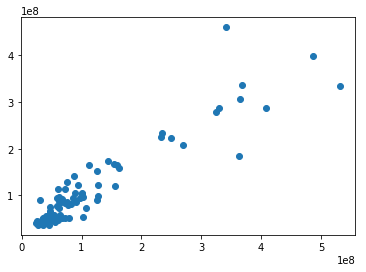

In [48]:
gradient_boost = GradientBoostingRegressor()
gradient_boost.fit(trainX,trainY)
print gradient_boost
evaluate(gradient_boost)

In [54]:
columns = trainX.columns
importances = random_forest.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. theaters (0.779115)
2. budget (0.125304)
3. Lionsgate (0.008803)
4. Universal (0.007821)
5. Action (0.006734)
6. Adventure (0.005261)
7. Warner Bros. (0.005234)
8. Animation/Live Action (0.004812)
9. Original Screenplay (0.004492)
10. Fantasy (0.004297)


## Next Steps
There's a lot we can do to further improve our predictions:
* There are other parameters to tune for all the algorithms we've looked at
* We can add new features to our data... director, cast, MPAA rating
* We can get new training examples from other years
* Other regression techniques... K-nearest neighbors, local regression, generalized Linear models, neural nets
* Model stacking

**Get To It!**